# PROJETO INTEGRADOR III - Modelo de aprendizagem de máquina

### Parâmetros que podem ser usados para definir a aprovação:

- nota (de cada área de conhecimento e com peso, mesmo que todos sejam iguais a 1);
- cotas (vou precisar tratar isso aqui);
- notas de corte;
- curso (vou precisar tratar isso aqui);
- universidade (vou precisar tratar isso aqui: campus, IES ou o que?);
- Local da IES;
- local do candidato;


### feature engineering

pontos importantes para serem destacados:

- *notas*: tratar os dados que estão fora da distribuição normal;
- *cotas, curso e universidade*: considerar usar um target encoding ou count encoding;
- *notas de corte*: talvez não será necessário passar por um tratamento;
- *locais*: pode ser usado um label encoding, mas é necessário avaliar o contexto. oneHotEncoding seria muito custoso ( 27 * 2 + 54 = 108 colunas).


### Avaliação de modelo de linguagem
precisão, recall, acurácia e área sob a curva ROC (Receiver Operating Characteristic).


In [1]:
# dataframes
import pandas as pd
import numpy as np

# visualizacao
import matplotlib.pyplot as plt

# conexão com o banco de dados
import psycopg2 as pspg
CONN = pspg.connect(database='notas', user='dev', password='dev', host='localhost', port='5030')

# feature engineering
from category_encoders.target_encoder import TargetEncoder
from category_encoders.count import CountEncoder
from sklearn.preprocessing import (OrdinalEncoder, OneHotEncoder, Normalizer, StandardScaler )

# algoritmos de classificação 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestNeighbors

# metricas e validacoes
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve )
from sklearn.model_selection import cross_val_score, train_test_split


In [2]:
df = pd.read_sql('''
  select 
    nota_l,
    nota_ch,
    nota_cn,
    nota_m,
    nota_r,
    nota_l_com_peso,
    nota_ch_com_peso,
    nota_cn_com_peso,
    nota_m_com_peso,
    nota_r_com_peso,
    nota_candidato,
    tipo_mod_concorrencia,
    tp_cota,
    uf_ies,
    uf_candidato,
    nome_curso,
    nome_ies,
    aprovado
  from sisu_data
  tablesample bernoulli(25)
  ''', con=CONN)
CONN.close()

/tmp/ipykernel_178394/2970485217.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('''


## ENGINEERING

## modalidade de concorrência: _one hot encoding_

tirando espaços em branco da coluna `tp_cota`

In [3]:
df['tp_cota'] = df['tp_cota'].str.strip()
df['tp_cota'].unique()

array([None, 'PPI', 'D', 'PPID', 'DD', 'I', 'PP', 'PPD'], dtype=object)

In [4]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
columns = ['tipo_mod_concorrencia',  'tp_cota']

print(df.shape)
for column in columns:
    transformed = ohe.fit_transform(df[column].values.reshape(-1, 1))
    ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names_out([column]))
    df = pd.concat([df, ohe_df], axis=1)

print(df.shape)

(3864339, 18)
(3864339, 30)


### Unidades Federativas: _Ordinal Encoding_ por ordem de concorrência

In [5]:
ordinals = ['uf_ies', 'uf_candidato', 'aprovado']
le = None
for column in ordinals:
    estados_ordenados = df.groupby(column)['nota_candidato'].mean().sort_values(ascending=False).index
    le = OrdinalEncoder(categories=[estados_ordenados.tolist()])
    df[f"{column}_le"] = le.fit_transform(df[column].values.reshape(-1, 1), estados_ordenados)



## Universidades e Cursos: Codificação de frequência (_Count Encoder_)

In [6]:
counters = [ 'nome_curso', 'nome_ies']
ce = CountEncoder()
for column in counters:
    transformed = ce.fit_transform(df[column].values.reshape(-1, 1))
    df[f"{column}_ce"] = ce.fit_transform(df[column].values.reshape(-1, 1))

### notas: removendo outliers

removendo as notas consideradas _outliers_ do conjunto de dados para fazer o treinamento 

In [7]:
df_filtrado = df.copy()
notas = ['nota_l','nota_ch', 'nota_cn',
        'nota_m', 'nota_r', 'nota_candidato']


for nota in notas:
    primeiro_quartil = df[nota].quantile(0.25)
    terceiro_quartil = df[nota].quantile(0.75)
    iqr = terceiro_quartil - primeiro_quartil
    limite_inferior = primeiro_quartil - 1.5 * iqr
    limite_superior = terceiro_quartil + 1.5 * iqr
    df_filtrado = df_filtrado[(df_filtrado[nota] >= limite_inferior) & (df_filtrado[nota] <= limite_superior)]


In [8]:
# colunas_necessárias
ml_params = [
    'nota_l_com_peso',          #ok
    'nota_ch_com_peso',         #ok
    'nota_cn_com_peso',         #ok
    'nota_m_com_peso',          #ok
    'nota_r_com_peso',          #ok
    'nota_candidato',           #ok
    # 'nota_corte',               # pegar a média do curso por universidade?

#    'qt_vagas_concorrencia',    # ajudaria muito, mas tem muitos registros NaN. sem chances de usar
    # tipo_mod_concorrencia com oneHotEncoder
    'tipo_mod_concorrencia_A', # ok
    'tipo_mod_concorrencia_B', # ok
    'tipo_mod_concorrencia_L', # ok
    'tipo_mod_concorrencia_V', # ok
    'tp_cota_D',               # ok
    'tp_cota_DD',              # ok
    'tp_cota_I',               # ok
    'tp_cota_PP',              # ok
    'tp_cota_PPD',             # ok
    'tp_cota_PPID',            # ok
    'tp_cota_None',            # ok
    'uf_ies_le',                  # ok
    'uf_candidato_le',            # ok
    'nome_curso_ce',
    'nome_ies_ce',
    'aprovado_le',
    ]

output_desejado = 'aprovado_le'

## Treinando o modelo

Modelos de M.L que podem ser usados:
  - *Decision Tree*;
  - *Naive Bayes*;


In [9]:
data_treinamento = df_filtrado[ml_params].sample(frac=0.9)
target = data_treinamento[output_desejado]
data_treinamento = data_treinamento.drop(output_desejado, axis=1)

data_validacao = df_filtrado.drop(data_treinamento.index)
target_validacao = data_validacao[output_desejado]
data_validacao = data_validacao.drop(output_desejado, axis=1)


In [10]:
df_filtrado[ml_params].drop('aprovado_le', axis=1)

,nota_l_com_peso,nota_ch_com_peso,nota_cn_com_peso,nota_m_com_peso,nota_r_com_peso,nota_candidato,tipo_mod_concorrencia_A,tipo_mod_concorrencia_B,tipo_mod_concorrencia_L,tipo_mod_concorrencia_V,...,tp_cota_DD,tp_cota_I,tp_cota_PP,tp_cota_PPD,tp_cota_PPID,tp_cota_None,uf_ies_le,uf_candidato_le,nome_curso_ce,nome_ies_ce
0,454.3,510.8,943.4,2645.6,2580.0,648.55,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,36861,13526
1,578.7,604.4,969.2,2594.0,1980.0,611.48,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,36861,13526
2,607.7,713.0,1295.0,3144.4,2700.0,769.10,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,36861,13526
3,615.1,645.1,1334.8,2972.4,2040.0,691.58,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,36861,13526
4,599.2,682.8,1113.6,2107.2,2580.0,643.89,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,36861,13526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3864334,575.4,628.0,593.4,592.1,1400.0,631.48,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,5096,45731
3864335,658.1,689.4,537.1,646.5,1400.0,655.18,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,5096,45731
3864336,526.7,522.5,428.2,483.8,1520.0,580.20,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,5096,45731
3864337,517.8,628.8,558.3,617.7,1320.0,607.10,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,5096,45731


In [11]:
X_train, X_val_test, y_train, y_val_test = \
train_test_split(
    df_filtrado[ml_params].drop(output_desejado, axis=1), 
    df_filtrado[output_desejado], 
    test_size=0.1, 
    random_state=42
)

X_test, X_val, y_test, y_val = \
    train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


In [12]:
n_bayes = MultinomialNB() #.fit(X_train, y_train)
decision_tree = DecisionTreeClassifier(random_state=0, criterion='log_loss', max_depth=4) # .fit(X_train, y_train)


In [13]:
models = [n_bayes, decision_tree]

for model in models:
    print(model)
    print(cross_val_score(model, X_train, y_train, cv=10).mean())
    print()
    print()

# print(nbrs)
# print(cross_val_score(nbrs, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())


MultinomialNB()
0.48252576728177504


DecisionTreeClassifier(criterion='log_loss', max_depth=4, random_state=0)
0.9239900648337613




In [14]:
n_bayes.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)

y_pred_test_nb = n_bayes.predict(X_test)
y_pred_test_dt = decision_tree.predict(X_test)
y_pred_val_nb = n_bayes.predict(X_val)
y_pred_val_dt = decision_tree.predict(X_val)

In [15]:
print("Métricas de classificação para Multinomial Naive Bayes no conjunto de teste: ")
print(classification_report(y_test, y_pred_test_nb))
print("\n")
print("Métricas de classificação para Árvore de Decisões no conjunto de teste: ")
print(classification_report(y_test, y_pred_test_dt))

Métricas de classificação para Multinomial Naive Bayes no conjunto de teste: 
              precision    recall  f1-score   support

         0.0       0.09      0.68      0.17     14289
         1.0       0.95      0.47      0.63    175452

    accuracy                           0.48    189741
   macro avg       0.52      0.57      0.40    189741
weighted avg       0.88      0.48      0.59    189741



Métricas de classificação para Árvore de Decisões no conjunto de teste: 


/home/gustavo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gustavo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     14289
         1.0       0.92      1.00      0.96    175452

    accuracy                           0.92    189741
   macro avg       0.46      0.50      0.48    189741
weighted avg       0.86      0.92      0.89    189741



/home/gustavo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


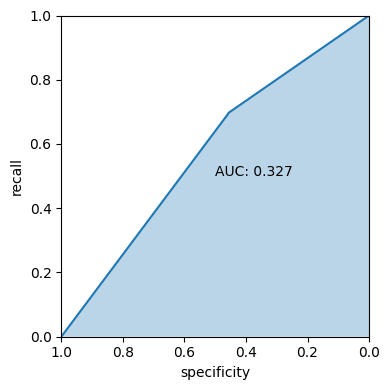

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, n_bayes.predict_proba(X_test)[:, 0], pos_label=0)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.text(0.5, 0.5, f'AUC: {np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)):.3f}')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

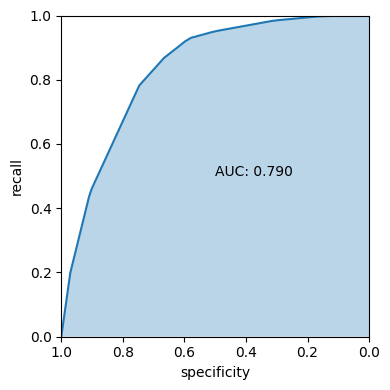

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, decision_tree.predict_proba(X_test)[:, 0], pos_label=0)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.text(0.5, 0.5, f'AUC: {np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)):.3f}')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()